In [217]:
import tensorflow as tf
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

file_path = "data/TSLA_time_series.csv"

df = pd.read_csv(file_path)
df

,open,high,low,close,volume,previous open,open-change,open-trend,previous high,high-change,...,percent_b,macd,macd_signal,macd_hist,adx,ema,rsi,day_of_week,hour,target
0,245.35,245.40,245.10,245.17,386816,243.69,1.66,1,243.80,1.60,...,0.85,0.82,0.76,0.05,46.51,244.81,71.07,1,10,1
1,245.19,245.72,244.87,244.96,673805,243.75,1.44,1,243.99,1.73,...,0.75,0.78,0.77,0.02,47.58,244.84,66.87,1,10,1
2,244.96,245.81,244.82,245.68,502824,243.53,1.43,1,243.92,1.89,...,0.93,0.81,0.77,0.03,48.65,245.01,72.78,1,10,1
3,245.70,246.65,245.51,246.54,1015053,243.74,1.96,1,244.33,2.32,...,1.08,0.88,0.80,0.09,50.28,245.31,77.77,1,10,1
4,246.52,246.56,246.12,246.13,531491,244.20,2.32,1,244.73,1.83,...,0.92,0.90,0.82,0.08,51.78,245.48,71.09,1,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,254.49,254.60,254.42,254.60,184960,253.83,0.66,1,254.18,0.42,...,0.81,0.11,0.09,0.02,13.26,254.50,58.96,3,15,0
4986,254.60,254.71,254.50,254.68,240090,254.16,0.44,1,254.47,0.24,...,0.87,0.12,0.10,0.02,12.48,254.53,61.36,3,15,0
4987,254.68,254.69,254.52,254.55,213734,254.47,0.21,1,254.48,0.21,...,0.70,0.11,0.10,0.01,11.75,254.54,55.97,3,15,0
4988,254.53,254.62,254.43,254.62,401556,254.40,0.13,1,254.41,0.21,...,0.76,0.11,0.10,0.01,11.56,254.55,58.10,3,15,0


In [218]:
def get_recent_time_series_batch() -> tuple:
    seq_length: int = 10
    target_column_name: str = "target"
    time_series_batch = []
    time_series_target = []

    for row in range(len(df) - seq_length):
        time_series_batch.append(df.iloc[row:row + seq_length].values)
        time_series_target.append(df[target_column_name].iloc[row + seq_length - 1])

    time_series_batch = np.array(time_series_batch)
    time_series_target= np.array(time_series_target)
    return time_series_batch, time_series_target

X, y = get_recent_time_series_batch()

"""
X is a list with contains (len(df) - seq_length) entries. The first entry is a list of the first seq_length rows of df. X[index][-1] gives you the (index + seq_length)-th row of df.
y is a list that contains (len(df) - seq_length) entries. The first entry is the "target" column of the seq_length row. X[index][-1][-1] and y[index] are the same "target" value.
If df has 5000 entries, X.shape y.shape will give you: ((4980, 10, 25), (4980,))
"""
X.shape, y.shape

((4980, 10, 30), (4980,))

In [219]:
# Split the data into training and temporary sets

test_size = 0.2

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Further split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=test_size, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Print the shapes of the sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (3187, 10, 30) (3187,)
Validation set shape: (797, 10, 30) (797,)
Test set shape: (996, 10, 30) (996,)


In [220]:
from keras.src.layers import LSTM, Dropout, Dense
from keras import Sequential

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

start_time = time.time()
history = model.fit(X_train, y_train, epochs=5, batch_size=1, validation_data=(X_val, y_val), callbacks=[early_stopping])
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/5
3187/3187 [==============================] - 11s 3ms/step - loss: 0.5626 - accuracy: 0.7258 - val_loss: 0.4219 - val_accuracy: 0.8206
Epoch 2/5
3187/3187 [==============================] - 9s 3ms/step - loss: 0.3355 - accuracy: 0.8808 - val_loss: 0.2751 - val_accuracy: 0.8833
Epoch 3/5
3187/3187 [==============================] - 9s 3ms/step - loss: 0.2257 - accuracy: 0.9190 - val_loss: 0.1923 - val_accuracy: 0.9272
Epoch 4/5
3187/3187 [==============================] - 9s 3ms/step - loss: 0.1487 - accuracy: 0.9548 - val_loss: 0.1133 - val_accuracy: 0.9862
Epoch 5/5
3187/3187 [==============================] - 9s 3ms/step - loss: 0.0841 - accuracy: 0.9931 - val_loss: 0.0606 - val_accuracy: 1.0000
Training time: 49.07 seconds


32/32 [==============================] - 0s 2ms/step - loss: 0.0625 - accuracy: 1.0000
Test Loss: 0.0625, Test Accuracy: 100.00%


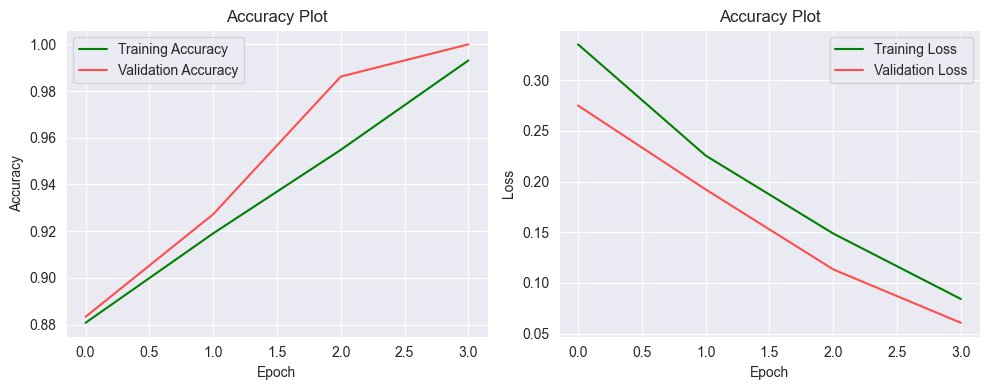

In [221]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(history.history['accuracy'][1:], label='Training Accuracy', color="green")
ax1.plot(history.history['val_accuracy'][1:], label='Validation Accuracy', color="#ff4d4d")

ax1.set_title('Accuracy Plot')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'][1:], label='Training Loss', color="green")
ax2.plot(history.history['val_loss'][1:], label='Validation Loss', color="#ff4d4d")

ax2.set_title('Accuracy Plot')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [222]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

y_actual = y_test
results_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred.flatten(), 'Predicted_Prob': y_pred_prob.flatten()})
results_df

32/32 [==============================] - 0s 2ms/step


,Actual,Predicted,Predicted_Prob
0,1,1,0.915338
1,1,1,0.969625
2,1,1,0.962856
3,1,1,0.978415
4,0,0,0.042789
...,...,...,...
991,0,0,0.016905
992,1,1,0.968745
993,1,1,0.980339
994,1,1,0.965561


In [223]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000


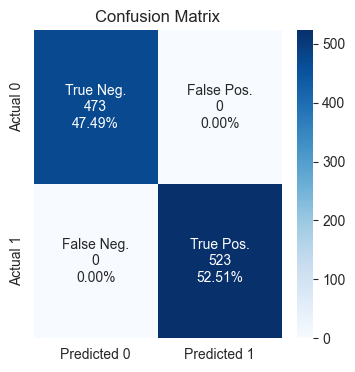

In [224]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(4, 4))

group_names = ["True Neg.","False Pos.","False Neg.","True Pos."]
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()